In [1]:
import sys
import os
sys.path.insert(0, os.path.realpath('../'))

import numpy as np
import matplotlib.pyplot as plt

import LDAQ

(300, 200, 300)

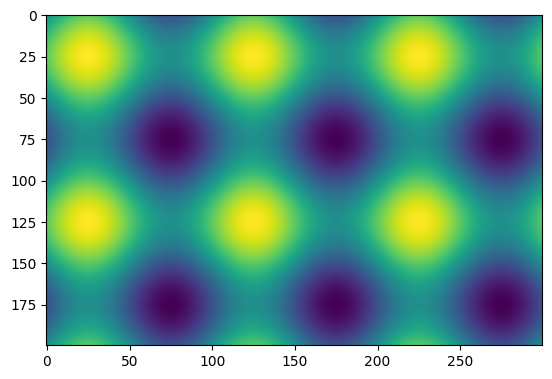

In [2]:
# Define simulated video using data:
fs = 30
freq_x  = 0.1
freq_y  = 0.3
waves_x = 3
waves_y = 2

height = 200
width  = 300
t_arr = np.arange((fs/freq_x) ) / fs
T, Y, X = np.meshgrid(t_arr, np.arange(height), np.arange(width), indexing='ij')
video_array = np.sin(2 * np.pi * X / width * waves_x + 2*np.pi*freq_x*T) + np.sin(2 * np.pi * Y / height * waves_y + 2*np.pi*freq_y*T)
video_array.shape

plt.imshow(video_array[0])
video_array.shape

In [3]:
# ------------------------------------------
# create simulated video acquisition source:
# ------------------------------------------
acq_simulated_video = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim_video')
acq_simulated_video.set_simulated_video(video_array, channel_name_video='2D_source', sample_rate=fs) # use array

In [4]:
def average_in_the_middle(ch, *args, **kwargs):
    """Takes 5x5 pixel array in the middle of the image and averages it.
    
    Args:
        ch (np.ndarray): channel array (samples, height, width)
        *args: arguments
        **kwargs: keyword arguments
        
    Returns:
        np.ndarray: averaged array (samples, 1)
        
    Notes:
        Let's say 'scale' kwarg will scale the average value.
    
    """
    scale = kwargs.get('scale', 1) # defaults to 1
    
    # get 5x5 array in the middle of the image
    height, width = ch.shape[1:]
    arr = ch[:, height//2-2:height//2+3, width//2-2:width//2+3]
    
    # compute mean, but keep samples dimension and reshape to (samples, 1)
    avg = np.mean(arr, axis=(1, 2)).reshape(-1, 1) * scale
    return avg

average_in_the_middle(video_array, scale=1.0).shape # check if shape is (samples, 1)

(300, 1)

In [5]:
# adds virtual channel to the acquisition source as data channel:
acq_simulated_video.add_virtual_channel(virtual_channel_name='average', source_channels='2D_source', function=average_in_the_middle, scale=1.0 )

In [6]:
# ----------------------------
# Create visulaization object:
# ----------------------------
vis = LDAQ.Visualization()
vis.add_lines((0,0), source='sim_video', channels="average", refresh_rate=33)
vis.add_image(source="sim_video", channel="2D_source", refresh_rate=300, colormap="cividis")

vis.config_subplot((0,0), t_span=30)

In [7]:
# --------------------
# Create Core object:
# --------------------
ldaq = LDAQ.Core(acquisitions=[acq_simulated_video], visualization=vis)
ldaq.set_trigger(
    source="sim_video",
    channel="average", # trigger set on virtual channel
    level  = 1.0,
    presamples=10,     # 10 presamples
    duration  =60.,    # 60 seconds
    trigger_type="up"
)

ldaq.run(
    save_interval=5., # each 5 seconds, save data. 
    root="", 
    run_name="periodic_saving_1",
    save_channels=["2D_source", "average"] # choose which channels will you save.
                                           # i.e. saving only data channels saves a lot of space.
)

# IMPORTANT:
# - when using periodic saving, buffer size is set to number of samples 
#   that equal to 5*1.5 seconds. ldaq.get_measurement_duct() will therefore NOT
#   return full measurement data.
# - periodic saving will make a new file each time file size is greater than 200 MB.
# - use LDAQ.load_measurement_multiple_files() to load whole measurement (see below) 

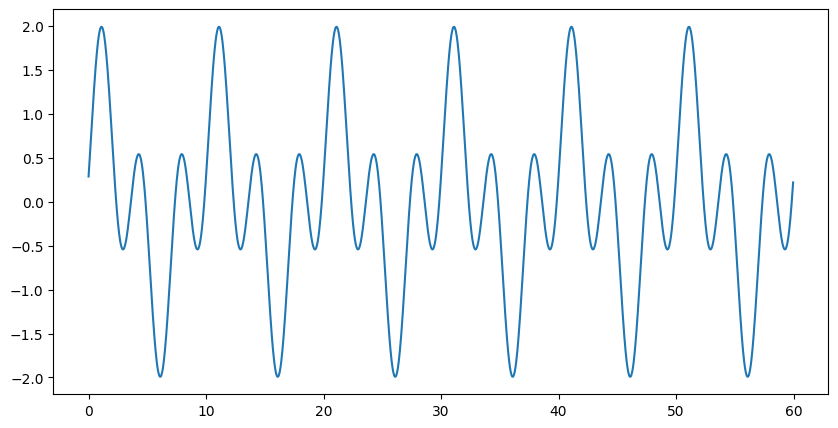

In [9]:
# load whole measurement
meas = LDAQ.load_measurement_multiple_files(directory=None, contains="periodic_saving_1")

# plot data channel:
time = meas["sim_video"]["time"]
data = meas["sim_video"]["data"]
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(time, data)